## Classification of cell type

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input

from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
import tensorflow as tf






In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!ls /content/drive/'My Drive'/CML/

Image_classification_data.zip
ruwanten-rmit-cosc2673_2793-2110-6e7ef3b65f3e.zip


In [12]:
!cp /content/drive/'My Drive'/CML/Image_classification_data.zip .
!unzip -q -o Image_classification_data.zip
!rm Image_classification_data.zip
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


In [13]:
import pandas as pd
import numpy as np
data = pd.read_csv('./data_labels_mainData.csv',delimiter=',')
data.head(5)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [14]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [15]:
data['ImagePath'] = 'patch_images/' + data['ImageName'].astype(str)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42,stratify = data.patientID)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify = train_data.patientID)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [17]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

In [28]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 64

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImagePath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImagePath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [30]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImagePath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
INPUT_DIM = (27,27,3)
#HIDDEN_LAYER_DIM = 256

OUTPUT_CLASSES = 4

In [31]:
def build_model_MLP( learning_rate, Hidden_layer):
    OUTPUT_CLASSES=4

    model_MLP = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(Hidden_layer, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
    ])
    
    model_MLP.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
    

    monitor=EarlyStopping(monitor='val_loss',min_delta=1e-5,patience=80,verbose=1,restore_best_weights=True)
    model_history = model_MLP.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

    plot_learning_curve(model_history.history['loss'], model_history.history['val_loss'], 
                    model_history.history['categorical_accuracy'], model_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
    print("Performance on test data: ", str(model_MLP.evaluate(test_generator)))
        
    return model_MLP

learning_rate= 0.001 , Neurons in Hidden layer= 128


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


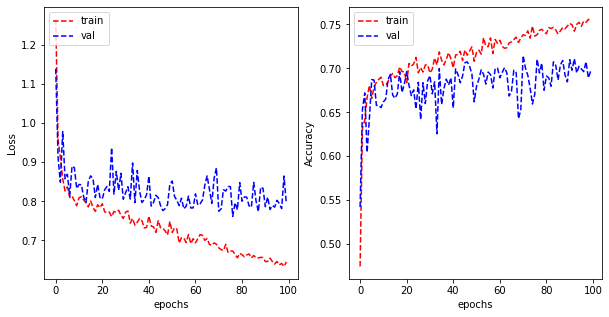

1980/1980 [==============================] - 4s 2ms/step - loss: 0.7683 - categorical_accuracy: 0.7005
Performance on test data:  [0.7683084607124329, 0.7005050778388977]
* End of iteration *

learning_rate= 0.001 , Neurons in Hidden layer= 256


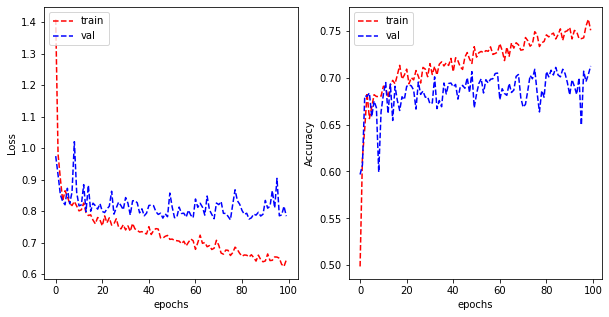

1980/1980 [==============================] - 4s 2ms/step - loss: 0.7486 - categorical_accuracy: 0.7146
Performance on test data:  [0.7485873103141785, 0.7146464586257935]
* End of iteration *

learning_rate= 0.01 , Neurons in Hidden layer= 128


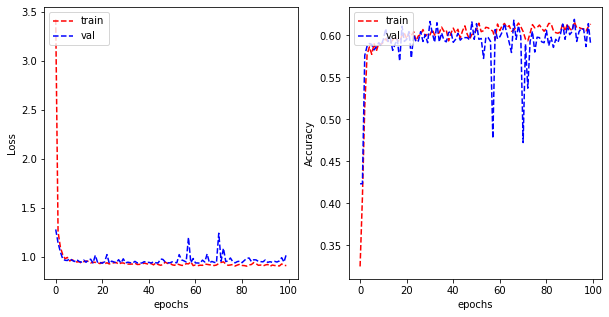

1980/1980 [==============================] - 4s 2ms/step - loss: 1.0163 - categorical_accuracy: 0.5894
Performance on test data:  [1.0163342952728271, 0.5893939137458801]
* End of iteration *

learning_rate= 0.01 , Neurons in Hidden layer= 256


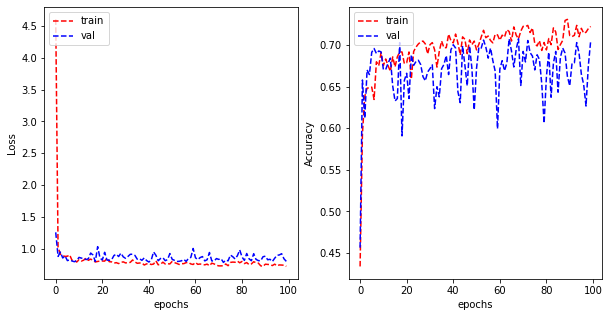

1980/1980 [==============================] - 4s 2ms/step - loss: 0.7742 - categorical_accuracy: 0.7121
Performance on test data:  [0.7742292284965515, 0.7121211886405945]
* End of iteration *



In [32]:
learning_rate = [0.001, 0.01]
Hidden_layer = [128, 256]

for lr in learning_rate:
    for hl in Hidden_layer:
        print("learning_rate=",lr,", Neurons in Hidden layer=",hl)
                
        build_model_MLP(lr, hl)
        
        print("* End of iteration *")
            
        print()

### Trying data augmentation to improve the model 

In [13]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImagePath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImagePath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [14]:

reg_lambda = 0.001

model_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
       
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [15]:
model_VGG_3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_VGG_3 = model_VGG_3.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)


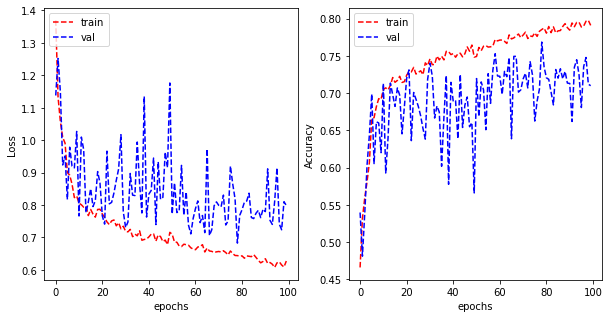

In [18]:
plot_learning_curve(history_VGG_3.history['loss'], history_VGG_3.history['val_loss'], 
                    history_VGG_3.history['categorical_accuracy'], history_VGG_3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')